In [1]:
import numpy as np
import pandas
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random
from tqdm.notebook import trange, tqdm
from time import sleep


from Helper.ImportDatasetsFOMLAS import df_epsilon, df_epsilon_crit
from Method.calculate_distribution_a import distribution_a
plt.ioff()

# run for new data

In [29]:
def run(network, ani = False, shuffle = False, step_size_a = 0.001, sigma = 0.05, n_samples = 1000, n_a_samples = 10, uncertainty = 0.001, metrics = False, verbosity = 0):
    
    # Get the network and test set, then split the images
    df_for_network = df_epsilon[df_epsilon['network'] == network]
    df_for_network = df_for_network[df_for_network['ds'] == 'test']
    df_per_image = [df_for_network[df_for_network['image'] == i] for i in df_for_network['image'].unique()]
    df_epsilon_crit_for_network = df_epsilon_crit[df_epsilon_crit['network'] == network]
    df_epsilon_crit_for_network = df_epsilon_crit_for_network[df_epsilon_crit_for_network['ds'] == 'test']
    
    # We find the distribution of 'a' for the following bins, number represents left side of bin
    a = torch.arange(step_size_a,0.4,step_size_a)
    
    # We keep track of the distributions of 'a' and its max probability
    distributions_of_a = []
    
    # We keep track of what bins of 'a' we use
    a_bins = []
    
    # We keep track of the images we use
    images = []
    
    # Initialize D (dataset) and the default value to put in if we don't find elligible epsilons
    D = torch.tensor([[],[]],dtype=torch.float32)
    default = torch.tensor([[0],[0.4]],dtype=torch.float32)
    
    if shuffle:
        random.shuffle(df_per_image)
    
    total_runtime = 0
    for i,image in enumerate(df_per_image):
        
        img = image['image'].values[0]
        images.append(img)
        
        # We keep track of the runtime
        # check if we have the runtime
        if img not in df_epsilon_crit_for_network['image'].values:
            print(f"image {i+1}")
            print(f"image {img} not in df_epsilon_crit_for_network")
            runtime = df_for_network[df_for_network['image'] == img]['runtime'].sum()
        else:
            runtime = df_epsilon_crit_for_network[df_epsilon_crit_for_network['image'] == img]['runtime'].values[0]
        total_runtime += runtime
            
        # We put in the default value first and then change it to the lower and upper bound of the image
        D = torch.cat((D,default),dim=1)
        
        # unsat means epsilon >, thus lower bound
        lower_bound = np.max(image[image['result']=='unsat']['epsilon'].values, initial = default[0,-1])
        # sat means epsilon <, thus upper bound
        upper_bound = np.min(image[image['result']=='sat']['epsilon'].values, initial = default[1,-1])
        D[0,-1] = lower_bound
        D[1,-1] = upper_bound
        
        # print(f"image {i+1}")
        
        # Sample in our bins of 'a', 100 samples are taken per bin
        a_samples = torch.rand(n_a_samples,*a.shape)*step_size_a+a
        # We calculate the distribution of each sample
        distr = distribution_a(a_samples,D,sigma,n_samples)
        max_distr = torch.max(distr)
        distributions_of_a.append(distr)
        a_bins.append(a)
        
        # If the distribution of 'a' becomes 0 we stop the search
        if torch.isnan(max_distr):
            distributions_of_a.pop()
            a_bins.pop()
            images.pop()
            total_runtime -= runtime
            if verbosity > 0:
                print('found: surrogate model too strict')
            break
        
        # We adapt the area in which we search for 'a' based on the distribution
        indices = torch.where(distr != 0)[0]
        left_bound_ind = torch.min(indices)
        right_bound_ind = torch.max(indices)
        
        # We update the bounds
        left_bound = a[left_bound_ind]
        right_bound = a[right_bound_ind]
        
        # We check if the required uncertainty has been reached
        if right_bound-left_bound < 2*uncertainty:
            print('found: uncertainty reached')
            break
        
        # We update the range of 'a' we search in
        step_size_a = (right_bound-left_bound)/200
        a = torch.arange(left_bound,right_bound,step_size_a)
        
        # make plots
        # fig, ax = plt.subplots()
        # ax.scatter(final_bins, final_distribution)
        # ax.axvline(quantile, color='r')
        # ax.axvline(quantile-0.002, color='g')
        
    
    if ani:
        fig, ax = plt.subplots()
    
        ax.set_ylim(0, 0.1)
        ax.set_xlim(0,0.2)
        line, = ax.plot(a, np.tile(0,len(a)))
        
        
        def animate(i):
            line.set_ydata(distributions_of_a[i])  # update the data.
            line.set_xdata(a_bins[i])
            return line,
        
        
        ani = animation.FuncAnimation(
            fig, animate, frames=len(distributions_of_a), interval=20, blit=True, save_count=50)
        
        # To save the animation, use e.g.
        #
        ani.save(network+".gif")
        
    else:
        return distributions_of_a, a_bins, total_runtime, images

In [25]:
# drop mnist-net, mnist-net_256x4 and mnist_relu_4_1024 from df's
df_epsilon = df_epsilon[df_epsilon['network'] != 'mnist-net']
df_epsilon = df_epsilon[df_epsilon['network'] != 'mnist-net_256x4']
df_epsilon = df_epsilon[df_epsilon['network'] != 'mnist_relu_4_1024']

df_epsilon_crit = df_epsilon_crit[df_epsilon_crit['network'] != 'mnist-net']
df_epsilon_crit = df_epsilon_crit[df_epsilon_crit['network'] != 'mnist-net_256x4']
df_epsilon_crit = df_epsilon_crit[df_epsilon_crit['network'] != 'mnist_relu_4_1024']

In [30]:
networks = df_epsilon['network'].unique()

In [31]:
len(networks)

9

In [32]:
# save final distributions and bins
distrs = []

i=0
for network in networks:
    i+=1
    print(f"network {i}: {network}")
    for runs in tqdm(range(100), desc = f'network {network} runs'):
        
        distr, a_bins, runtime, images = run(network, metrics=True, shuffle = True)
        distrs.append([network, a_bins[-1], distr[-1], runtime, images, runs])


# Put the distribution with the bins in  adataframe
distrs = pd.DataFrame(distrs, columns=['network', 'bins', 'distribution', 'runtime', 'images', 'run'])

distrs.to_pickle('Datasets\distributions_fomlas.pkl')

network 1: mnist-net_256x2


network mnist-net_256x2 runs:   0%|          | 0/100 [00:00<?, ?it/s]

found: uncertainty reached
found: uncertainty reached
found: uncertainty reached
found: uncertainty reached
found: uncertainty reached
found: uncertainty reached
found: uncertainty reached
found: uncertainty reached
found: uncertainty reached
found: uncertainty reached
network 2: mnist-net_256x6


network mnist-net_256x6 runs:   0%|          | 0/100 [00:00<?, ?it/s]

found: uncertainty reached
network 3: mnist_nn


network mnist_nn runs:   0%|          | 0/100 [00:00<?, ?it/s]

found: uncertainty reached
found: uncertainty reached
found: uncertainty reached
found: uncertainty reached
found: uncertainty reached
found: uncertainty reached
found: uncertainty reached
found: uncertainty reached
network 4: mnist_relu_3_100


network mnist_relu_3_100 runs:   0%|          | 0/100 [00:00<?, ?it/s]

found: uncertainty reached
found: uncertainty reached
found: uncertainty reached
found: uncertainty reached
network 5: mnist_relu_3_50


network mnist_relu_3_50 runs:   0%|          | 0/100 [00:00<?, ?it/s]

found: uncertainty reached
found: uncertainty reached
found: uncertainty reached
network 6: mnist_relu_6_100


network mnist_relu_6_100 runs:   0%|          | 0/100 [00:00<?, ?it/s]

found: uncertainty reached
network 7: mnist_relu_6_200


network mnist_relu_6_200 runs:   0%|          | 0/100 [00:00<?, ?it/s]

found: uncertainty reached
network 8: mnist_relu_9_100


network mnist_relu_9_100 runs:   0%|          | 0/100 [00:00<?, ?it/s]

found: uncertainty reached
found: uncertainty reached
network 9: mnist_relu_9_200


network mnist_relu_9_200 runs:   0%|          | 0/100 [00:00<?, ?it/s]

found: uncertainty reached


In [53]:
no_runtime_images_net_2 = ['677','1022']
no_runtime_images_net_3 = ['548']

# check runtimes for those images
dat = df_epsilon[df_epsilon['network'] == networks[1]]
dat = dat[dat['ds'] == 'test']
dat = dat[dat['image'] == 1022]
dat_crit = df_epsilon_crit[df_epsilon_crit['network'] == networks[1]]
dat_crit = dat_crit[dat_crit['ds'] == 'test']
dat_crit = dat_crit[dat_crit['image'] == 1022]

runtime_extra_net_2 = dat['runtime'].sum()

dat = df_epsilon[df_epsilon['network'] == networks[2]]
dat = dat[dat['ds'] == 'test']
dat = dat[dat['image'] == 548]
dat_crit = df_epsilon_crit[df_epsilon_crit['network'] == networks[2]]
dat_crit = dat_crit[dat_crit['ds'] == 'test']
dat_crit = dat_crit[dat_crit['image'] == 548]

runtime_extra_net_3 = dat['runtime'].sum()

# check runtimes for those images
dat = df_epsilon[df_epsilon['network'] == networks[1]]
dat = dat[dat['ds'] == 'test']
dat = dat[dat['image'] == 677]
dat_crit = df_epsilon_crit[df_epsilon_crit['network'] == networks[1]]
dat_crit = dat_crit[dat_crit['ds'] == 'test']
dat_crit = dat_crit[dat_crit['image'] == 677]

runtime_extra_net_2_2 = dat['runtime'].sum()

In [80]:
for i,net in enumerate(networks):
    if i == 0:
        continue
    for run in range(100):
        if i == 1:
            if 1022 in distrs[distrs['network'] == net]['images'].iloc[run]:
                print(f'network {net} run {run} has image 1022')
                # get index of the run
                index = distrs[distrs['network'] == net].index[run]
                distrs.loc[index,'runtime'] += runtime_extra_net_2
                
            if 677 in distrs[distrs['network'] == net]['images'].iloc[run]:
                print(f'network {net} run {run} has image 677')
                index = distrs[distrs['network'] == net].index[run]
                distrs.loc[index,'runtime'] += runtime_extra_net_2_2
            
        if i == 2:
            if 548 in distrs[distrs['network'] == net]['images'].iloc[run]:
                print(f'network {net} run {run} has image 548')
                index = distrs[distrs['network'] == net].index[run]
                distrs.loc[index,'runtime'] += runtime_extra_net_3
        

network mnist-net_256x4 run 9 has image 1022
network mnist-net_256x4 run 29 has image 1022
network mnist-net_256x4 run 36 has image 1022
network mnist-net_256x4 run 50 has image 1022
network mnist-net_256x4 run 81 has image 1022
network mnist-net_256x4 run 92 has image 1022
network mnist_relu_4_1024 run 32 has image 548
network mnist_relu_4_1024 run 70 has image 548
network mnist_relu_4_1024 run 89 has image 548


In [2]:
# Importing the data
distributions_df_1 = pd.read_pickle('Datasets/distributions_fairness.pkl')
distributions_df_2 = pd.read_pickle('Datasets/distributions_fomlas.pkl')

distributions_df = pd.concat([distributions_df_1, distributions_df_2])

In [34]:
distributions_df

,network,bins,distribution,runtime,images,run
0,mnist-net,"[tensor(0.0091), tensor(0.0092), tensor(0.0093...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",118411.854467,"[516, 49, 697, 87, 193, 181, 833, 297, 700, 40...",0
1,mnist-net,"[tensor(0.0010), tensor(0.0011), tensor(0.0011...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",77550.304662,"[533, 845, 88, 138, 459, 895, 272, 357, 267, 2...",1
2,mnist-net,"[tensor(0.0085), tensor(0.0086), tensor(0.0087...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",104138.536945,"[160, 595, 491, 871, 987, 546, 535, 807, 787, ...",2
3,mnist-net,"[tensor(0.0049), tensor(0.0050), tensor(0.0051...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",140782.403927,"[545, 804, 584, 150, 383, 109, 108, 689, 348, ...",3
4,mnist-net,"[tensor(0.0028), tensor(0.0029), tensor(0.0030...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",114566.330425,"[433, 491, 617, 504, 500, 586, 883, 426, 604, ...",4
...,...,...,...,...,...,...
895,mnist_relu_9_200,"[tensor(0.0126), tensor(0.0128), tensor(0.0129...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",236703.340350,"[65, 19, 43, 95, 90, 96, 12, 16, 25, 41, 87, 6...",95
896,mnist_relu_9_200,"[tensor(0.0105), tensor(0.0106), tensor(0.0108...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",219548.796045,"[77, 39, 65, 73, 74, 89, 47, 97, 11, 26, 48, 1...",96
897,mnist_relu_9_200,"[tensor(0.0076), tensor(0.0077), tensor(0.0078...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",217751.283244,"[48, 40, 53, 9, 67, 51, 39, 62, 28, 17, 79, 98...",97
898,mnist_relu_9_200,"[tensor(0.0038), tensor(0.0039), tensor(0.0041...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",219479.401202,"[32, 56, 96, 70, 72, 34, 77, 12, 98, 2, 17, 67...",98


In [35]:
# unique networks
networks = distributions_df['network'].unique()
len(networks)

12

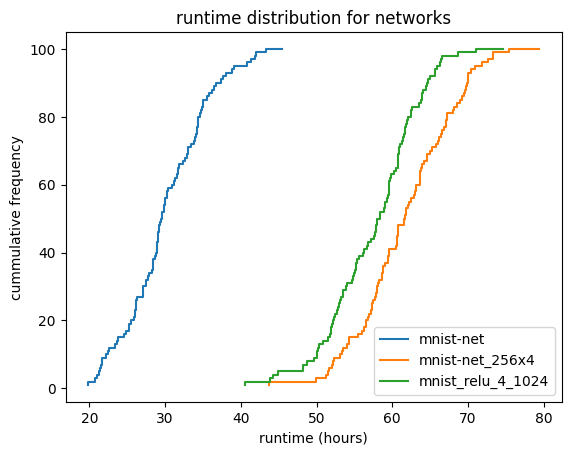

In [94]:
fig, ax = plt.subplots()
ax.set_xlabel('runtime (hours)')
ax.set_ylabel('cummulative frequency')
# per network make histograms of the runtimes
for net in networks[:3]:
    runtimes = np.array(distributions_df[distributions_df['network'] == net]['runtime'])
    sorted = np.sort(runtimes)
    
    # average consecutive difference
    avg_diff = np.mean(np.diff(sorted))
    
    # add last edge
    #sorted = np.append(sorted, sorted[-1]+avg_diff)
    

    #ax.stairs(np.arange(1, 101), sorted)
    ax.step(sorted/3600, np.arange(1, 101), label = net)

    # ax.set_title('runtime distribution for network ' + net)
    # fig.savefig('Figures/runtime_distribution_' + net + '.pdf', bbox_inches='tight', dpi=300)

# legend and title
ax.legend(loc='lower right')
ax.set_title('runtime distribution for networks')
# save figure
fig.savefig('Figures/runtime_distribution_all.pdf', bbox_inches='tight', dpi=300)

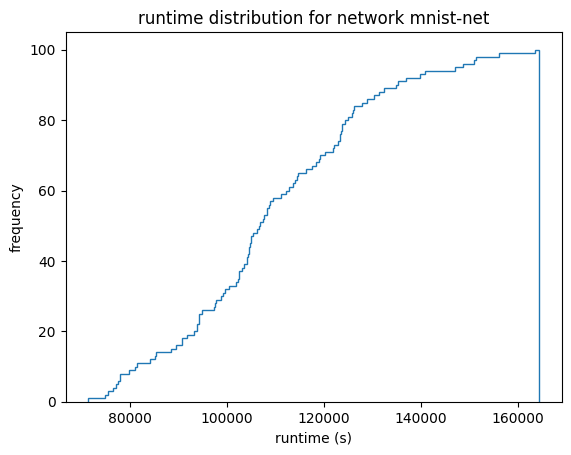

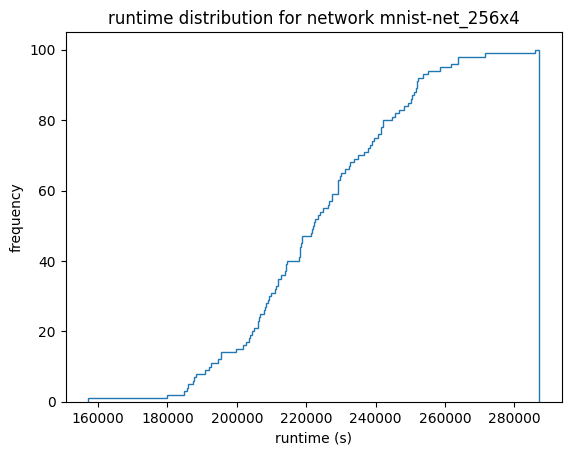

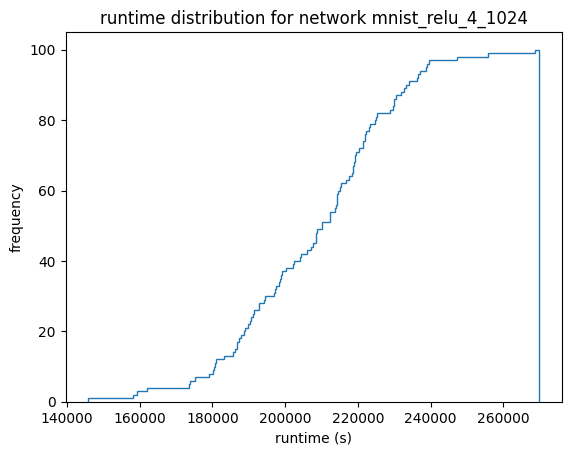

In [125]:
# per network make histograms of the runtimes
for net in networks[:3]:
    runtimes = np.array(distributions_df[distributions_df['network'] == net]['runtime'])
    sorted = np.sort(runtimes)
    
    # average consecutive difference
    avg_diff = np.mean(np.diff(sorted))
    
    # add last edge
    sorted = np.append(sorted, sorted[-1]+avg_diff)
    
    fig, ax = plt.subplots()
    ax.stairs(np.arange(1, 101), sorted)
    #ax.step(sorted, np.arange(1, 101))
    ax.set_xlabel('runtime (s)')
    ax.set_ylabel('frequency')
    ax.set_title('runtime distribution for network ' + net)
    #fig.savefig('Figures/runtime_distribution_' + net + '.pdf', bbox_inches='tight', dpi=300)

In [3]:
from Helper.ImportDatasetsFOMLAS import df_epsilon, df_epsilon_crit
from Helper.ImportDatasetsFairness import df_epsilon as df_epsilon_2
from Helper.ImportDatasetsFairness import df_epsilon_crit as df_epsilon_crit_2

# drop mnist-net, mnist-net_256x4 and mnist_relu_4_1024 from first df's
df_epsilon = df_epsilon[df_epsilon['network'] != 'mnist-net']
df_epsilon = df_epsilon[df_epsilon['network'] != 'mnist-net_256x4']
df_epsilon = df_epsilon[df_epsilon['network'] != 'mnist_relu_4_1024']

df_epsilon_crit = df_epsilon_crit[df_epsilon_crit['network'] != 'mnist-net']
df_epsilon_crit = df_epsilon_crit[df_epsilon_crit['network'] != 'mnist-net_256x4']
df_epsilon_crit = df_epsilon_crit[df_epsilon_crit['network'] != 'mnist_relu_4_1024']

# concat
df_epsilon = pd.concat([df_epsilon_2, df_epsilon])
df_epsilon_crit = pd.concat([df_epsilon_crit_2, df_epsilon_crit])

In [10]:
# get unique networks
networks = df_epsilon['network'].unique()

# get total runtime of all images for each network and print as latex table
for net in networks:
    total_runtime = df_epsilon[df_epsilon['network'] == net]['runtime'].sum()
    print(f'\\hline {net} & {total_runtime/3600:.0f} \\\\')


\hline mnist-net & 4049 \\
\hline mnist-net_256x4 & 9631 \\
\hline mnist_relu_4_1024 & 10792 \\
\hline mnist-net_256x2 & 433 \\
\hline mnist-net_256x6 & 1717 \\
\hline mnist_nn & 361 \\
\hline mnist_relu_3_100 & 1155 \\
\hline mnist_relu_3_50 & 827 \\
\hline mnist_relu_6_100 & 1185 \\
\hline mnist_relu_6_200 & 1219 \\
\hline mnist_relu_9_100 & 1153 \\
\hline mnist_relu_9_200 & 1737 \\


In [5]:
# get unique networks
networks = df_epsilon['network'].unique()
len(networks)

12

In [61]:
from scipy.special import comb

def binomial(n, p, x):
    '''
    :param n: number of trials
    :param p: probability of success, value of a (quantile)
    :param x: number of successes

    :return: probability of x successes
    '''

    return comb(n, x) * (p ** x) * ((1 - p) ** (n - x))

def binomial_bounds(n, p, alpha):
    '''
    :param n: number of trials
    :param p: probability of success, value of a (quantile)
    :param alpha: confidence interval

    :return: lower and upper bound of confidence interval
    '''
    probs = np.arange(0, n + 1)
    probs = binomial(n, p, probs)

    # take sum of probabilities until we reach alpha/2
    cumulated_probs = np.cumsum(probs)
    lower_index = np.where(cumulated_probs <= alpha / 2)[0][-1]
    upper_index = np.where(cumulated_probs >= 1 - alpha / 2)[0][0]

    return lower_index, upper_index

def get_quantile(network, sigma):
    '''
    :param network: name of network
    :param sigma: quantile

    :return: confidence interval for sigma quantile
    '''

    # Take all critical epsilons of the test set and put into numpy array
    df_for_network = df_epsilon_crit[df_epsilon_crit['network'] == network]
    df_for_network = df_for_network[df_for_network['ds'] == 'test']
    # remove nans
    df_for_network = df_for_network.dropna()
    crit_epsilons = df_for_network['Epsilon'].to_numpy()
    
    n = len(crit_epsilons)

    # We sort the critical epsilons
    order_statistics = np.sort(crit_epsilons)
    # We use the order statistics to estimate the sigma quantile
    index = int(n * sigma) + 1  # As given by David et al. 1986
    lower_index, upper_index = binomial_bounds(n, sigma, 0.05)
    return order_statistics[index], order_statistics[lower_index], order_statistics[upper_index]

In [9]:
import os

# for each network and run create plot of final distribution with confidence interval
networks = df_epsilon['network'].unique()


for network in networks:
    for run in range(10):
        path = 'Figures/Final distribution with confidence interval fariness/'+network+'/'
        if not os.path.exists(path):
            os.makedirs(path)
        
        final_bins = distributions_df[distributions_df['network'] == network]['bins'].iloc[run]
        final_distribution = distributions_df[distributions_df['network'] == network]['distribution'].iloc[run]
        
        quantile, lower, upper = get_quantile(network, 0.05)
        
        #make plots
        fig, ax = plt.subplots()
        ax.bar(final_bins, final_distribution, align = 'edge', width=final_bins[1]-final_bins[0], label='final distribution')
        #ax.axvline(quantile, color='y', label='quantile estimation')
        #ax.axvline(quantile+0.002, color='y')
        ax.axvline(lower, color='r', label='95% confidence interval')
        ax.axvline(upper+0.002, color='r')
        
        # labels
        ax.set_xlabel('epsilon')
        ax.set_ylabel('probability')
        ax.set_title('Final distribution of epsilon for network ' + network + ' run ' + str(run))
        # make legend smaller
        ax.legend(loc='upper left', prop={'size': 8})
        
        plt.close(fig)
        # save figure
        fig.savefig(path + 'final_distribution_' + network + '_' + str(run) + '.png', bbox_inches='tight')

In [62]:
# make 95% confidence intervals from the distributions
conf_intervals = np.tile(0., (len(networks), 100, 2))

for net,network in enumerate(networks):
    for run in range(100):
        final_bins = distributions_df[distributions_df['network'] == network]['bins'].iloc[run]
        final_distribution = distributions_df[distributions_df['network'] == network]['distribution'].iloc[run]
        cumsum = np.cumsum(final_distribution)
        lower_index = np.where(cumsum <= 0.025)[0][-1]
        upper_index = np.where(cumsum >= 0.975)[0][0]
        
        bin_size = final_bins[1] - final_bins[0]
        
        conf_intervals[net, run, 0] = final_bins[lower_index]
        conf_intervals[net, run, 1] = final_bins[upper_index] + bin_size

In [63]:
in_confidence_interval = np.tile(0, (len(networks), 100))
overlap = np.tile(0., (len(networks), 100))

for net,network in enumerate(networks):
    for run in range(100):
        final_bins = distributions_df[distributions_df['network'] == network]['bins'].iloc[run]
        final_distribution = distributions_df[distributions_df['network'] == network]['distribution'].iloc[run]
        quantile, lower, upper = get_quantile(network, 0.05)
        upper = upper + 0.002
        
        lower_bound_area = conf_intervals[net, run, 0]
        upper_bound_area = conf_intervals[net, run, 1]
        
        if lower_bound_area < upper <= upper_bound_area:
            metric = 1
        elif lower_bound_area <= lower < upper_bound_area:
            metric = 1
        elif lower <= lower_bound_area and upper >= upper_bound_area:
            metric = 1
        else:
            metric = 0
        
        in_confidence_interval[net, run] = metric
        
        
        

In [70]:
str = ''
for network in networks:
    name = network.replace('_','\_')
    str += name + ', '
print(str[:-2])

mnist-net, mnist-net\_256x4, mnist\_relu\_4\_1024, mnist-net\_256x2, mnist-net\_256x6, mnist\_nn, mnist\_relu\_3\_100, mnist\_relu\_3\_50, mnist\_relu\_6\_100, mnist\_relu\_6\_200, mnist\_relu\_9\_100, mnist\_relu\_9\_200


In [69]:
total = in_confidence_interval.sum(axis=1)

# make latex table

for net,network in enumerate(networks):
    name = network.replace('_',' ')
    print(f'\\hline {name} & {total[net]} \\\\')

\hline mnist-net & 95 \\
\hline mnist-net\_256x4 & 81 \\
\hline mnist\_relu\_4\_1024 & 86 \\
\hline mnist-net\_256x2 & 100 \\
\hline mnist-net\_256x6 & 98 \\
\hline mnist\_nn & 100 \\
\hline mnist\_relu\_3\_100 & 100 \\
\hline mnist\_relu\_3\_50 & 97 \\
\hline mnist\_relu\_6\_100 & 97 \\
\hline mnist\_relu\_6\_200 & 98 \\
\hline mnist\_relu\_9\_100 & 99 \\
\hline mnist\_relu\_9\_200 & 99 \\


In [86]:
for net,network in enumerate(networks):
    name = network.replace('_',' ')
    average_left_edge = np.mean(conf_intervals[net,:,0])
    average_right_edge = np.mean(conf_intervals[net,:,1])
    
    # ground truth interval
    quantile, lower_truth, upper_truth = get_quantile(network, 0.05)
    upper_truth = upper_truth + 0.002
    
    # worst case left interval
    worst_left_ind = np.argmin(conf_intervals[net,:,0])
    worst_left_interval = conf_intervals[net,worst_left_ind]
    
    # worst case right interval
    worst_right_ind = np.argmax(conf_intervals[net,:,1])
    worst_right_interval = conf_intervals[net,worst_right_ind]
    
    # min, max and average size of interval
    min_size = np.min(conf_intervals[net,:,1] - conf_intervals[net,:,0])
    max_size = np.max(conf_intervals[net,:,1] - conf_intervals[net,:,0])
    avg_size = np.mean(conf_intervals[net,:,1] - conf_intervals[net,:,0])
    
    # ground truth size
    truth_size = upper_truth - lower_truth
    
    print(f'\\hline {name} & {average_left_edge:.4f} & {average_right_edge:.4f} & ({lower_truth:.4f}, {upper_truth:.4f}) & ({worst_left_interval[0]:.4f}, {worst_left_interval[1]:.4f}) & ({worst_right_interval[0]:.4f}, {worst_right_interval[1]:.4f}) & {min_size:.4f} & {max_size:.4f} & {avg_size:.4f} & {truth_size:.4f} \\\\')

\hline mnist-net & 0.0102 & 0.0173 & (0.0090, 0.0170) & (0.0023, 0.0077) & (0.0151, 0.0254) & 0.0001 & 0.0109 & 0.0072 & 0.0080 \\
\hline mnist-net 256x4 & 0.0172 & 0.0306 & (0.0170, 0.0250) & (0.0043, 0.0100) & (0.0258, 0.0468) & 0.0002 & 0.0210 & 0.0134 & 0.0080 \\
\hline mnist relu 4 1024 & 0.0097 & 0.0218 & (0.0070, 0.0150) & (0.0014, 0.0077) & (0.0213, 0.0371) & 0.0004 & 0.0203 & 0.0121 & 0.0080 \\
\hline mnist-net 256x2 & 0.0126 & 0.0184 & (0.0070, 0.0210) & (0.0073, 0.0149) & (0.0179, 0.0261) & 0.0001 & 0.0089 & 0.0058 & 0.0140 \\
\hline mnist-net 256x6 & 0.0181 & 0.0304 & (0.0050, 0.0330) & (0.0046, 0.0178) & (0.0390, 0.0549) & 0.0019 & 0.0192 & 0.0123 & 0.0280 \\
\hline mnist nn & 0.0040 & 0.0082 & (0.0010, 0.0110) & (0.0015, 0.0046) & (0.0083, 0.0164) & 0.0003 & 0.0081 & 0.0042 & 0.0100 \\
\hline mnist relu 3 100 & 0.0142 & 0.0253 & (0.0050, 0.0310) & (0.0024, 0.0091) & (0.0304, 0.0438) & 0.0001 & 0.0169 & 0.0111 & 0.0260 \\
\hline mnist relu 3 50 & 0.0166 & 0.0264 & (0.0070,

In [12]:
distributions_df

,network,bins,distribution,runtime,images,run
0,mnist-net,"[tensor(0.0091), tensor(0.0092), tensor(0.0093...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",118411.854467,"[516, 49, 697, 87, 193, 181, 833, 297, 700, 40...",0
1,mnist-net,"[tensor(0.0010), tensor(0.0011), tensor(0.0011...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",77550.304662,"[533, 845, 88, 138, 459, 895, 272, 357, 267, 2...",1
2,mnist-net,"[tensor(0.0085), tensor(0.0086), tensor(0.0087...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",104138.536945,"[160, 595, 491, 871, 987, 546, 535, 807, 787, ...",2
3,mnist-net,"[tensor(0.0049), tensor(0.0050), tensor(0.0051...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",140782.403927,"[545, 804, 584, 150, 383, 109, 108, 689, 348, ...",3
4,mnist-net,"[tensor(0.0028), tensor(0.0029), tensor(0.0030...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",114566.330425,"[433, 491, 617, 504, 500, 586, 883, 426, 604, ...",4
...,...,...,...,...,...,...
895,mnist_relu_9_200,"[tensor(0.0126), tensor(0.0128), tensor(0.0129...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",236703.340350,"[65, 19, 43, 95, 90, 96, 12, 16, 25, 41, 87, 6...",95
896,mnist_relu_9_200,"[tensor(0.0105), tensor(0.0106), tensor(0.0108...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",219548.796045,"[77, 39, 65, 73, 74, 89, 47, 97, 11, 26, 48, 1...",96
897,mnist_relu_9_200,"[tensor(0.0076), tensor(0.0077), tensor(0.0078...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",217751.283244,"[48, 40, 53, 9, 67, 51, 39, 62, 28, 17, 79, 98...",97
898,mnist_relu_9_200,"[tensor(0.0038), tensor(0.0039), tensor(0.0041...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",219479.401202,"[32, 56, 96, 70, 72, 34, 77, 12, 98, 2, 17, 67...",98


In [14]:
for net, network in enumerate(networks):
    name = network.replace('_',' ')
    
    # min, max and average runtime
    min_runtime = np.min(distributions_df[distributions_df['network'] == network]['runtime'])
    max_runtime = np.max(distributions_df[distributions_df['network'] == network]['runtime'])
    avg_runtime = np.mean(distributions_df[distributions_df['network'] == network]['runtime'])
    
    # ground truth runtime
    ground_truth_runtime = df_epsilon[df_epsilon['network'] == network]['runtime'].sum()/3600
    
    # change seconds to hours
    min_runtime = min_runtime/3600
    max_runtime = max_runtime/3600
    avg_runtime = avg_runtime/3600
    
    print(f'\\hline {name} & {min_runtime:.2f} & {max_runtime:.2f} & {avg_runtime:.2f} & {ground_truth_runtime:.2f} \\\\')

\hline mnist-net & 19.85 & 45.38 & 30.32 & 4049.16 \\
\hline mnist-net 256x4 & 43.67 & 79.39 & 61.94 & 9631.47 \\
\hline mnist relu 4 1024 & 40.50 & 74.62 & 57.73 & 10791.52 \\
\hline mnist-net 256x2 & 2.68 & 14.58 & 8.09 & 432.95 \\
\hline mnist-net 256x6 & 49.53 & 80.41 & 62.12 & 1716.84 \\
\hline mnist nn & 3.80 & 19.55 & 11.52 & 360.63 \\
\hline mnist relu 3 100 & 38.02 & 64.08 & 49.29 & 1155.38 \\
\hline mnist relu 3 50 & 12.29 & 30.64 & 21.81 & 827.41 \\
\hline mnist relu 6 100 & 44.55 & 66.67 & 53.70 & 1184.82 \\
\hline mnist relu 6 200 & 45.34 & 67.69 & 56.10 & 1219.33 \\
\hline mnist relu 9 100 & 39.76 & 65.84 & 51.86 & 1153.48 \\
\hline mnist relu 9 200 & 51.18 & 77.18 & 62.74 & 1737.23 \\


In [83]:
# print(f'\\hline network & average lower bound & average upper bound & true 95\% confidence interval & lowest interval & highest interval & min size & max size & average size \\\\')
print(f'\\hline Network & Average lower bound & Average upper bound & True 95\% confidence interval & Lowest interval & Highest interval & Min size & Max size & Average size \\\\')

\hline Network & Average lower bound & Average upper bound & True 95\% confidence interval & Lowest interval & Highest interval & Min size & Max size & Average size \\


In [85]:
# make histogram
# first check lower bounds
net = 0

L_bigger_than_lower_bound = conf_intervals[net,:,0][:,np.newaxis] >= conf_intervals[net,:,0][np.newaxis,:]
L_smaller_than_upper_bound = conf_intervals[net,:,0][:,np.newaxis] < conf_intervals[net,:,1][np.newaxis,:]

# then check upper bounds
U_smaller_than_upper_bound = conf_intervals[net,:,1][:,np.newaxis] <= conf_intervals[net,:,1][np.newaxis,:]
U_bigger_than_lower_bound = conf_intervals[net,:,1][:,np.newaxis] > conf_intervals[net,:,0][np.newaxis,:]

# count amount
L_amount = (L_bigger_than_lower_bound*L_smaller_than_upper_bound).sum(axis=1)
U_amount = (U_smaller_than_upper_bound*U_bigger_than_lower_bound).sum(axis=1)


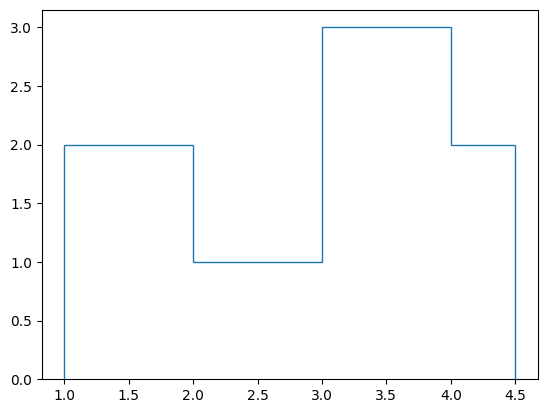

In [17]:
x = np.array([2,1,3,2])
edges = np.array([1,2,3,4,4.5])
plt.stairs(x, edges)

In [89]:
values

array([[2.34508025e-03, 1.00000000e+00, 0.00000000e+00],
       [2.59183720e-03, 2.00000000e+00, 0.00000000e+00],
       [3.47141968e-03, 3.00000000e+00, 0.00000000e+00],
       [4.40136995e-03, 4.00000000e+00, 0.00000000e+00],
       [4.43339907e-03, 5.00000000e+00, 0.00000000e+00],
       [4.70627612e-03, 6.00000000e+00, 0.00000000e+00],
       [5.35291107e-03, 7.00000000e+00, 0.00000000e+00],
       [5.38963685e-03, 8.00000000e+00, 0.00000000e+00],
       [5.49558923e-03, 9.00000000e+00, 0.00000000e+00],
       [5.50533971e-03, 1.00000000e+01, 0.00000000e+00],
       [5.58447186e-03, 1.10000000e+01, 0.00000000e+00],
       [5.65358205e-03, 1.20000000e+01, 0.00000000e+00],
       [5.69515256e-03, 1.30000000e+01, 0.00000000e+00],
       [6.01633964e-03, 1.40000000e+01, 0.00000000e+00],
       [6.15866249e-03, 1.50000000e+01, 0.00000000e+00],
       [6.15907693e-03, 1.60000000e+01, 0.00000000e+00],
       [6.30412484e-03, 1.70000000e+01, 0.00000000e+00],
       [6.85271714e-03, 1.80000

In [87]:

edges = np.copy(conf_intervals[net].reshape(-1, order = 'F'))
side = np.tile(0, edges.shape)
side[100:] = 1
amounts = np.copy(np.append(L_amount,U_amount))
# put all together into an array
values = np.stack((edges, amounts, side), axis = 1)

# sort by first index
ind = np.argsort(values[:,0])

values = values[ind]


In [92]:
values

array([[2.34508025e-03, 1.00000000e+00, 0.00000000e+00],
       [2.59183720e-03, 2.00000000e+00, 0.00000000e+00],
       [3.47141968e-03, 3.00000000e+00, 0.00000000e+00],
       [4.40136995e-03, 4.00000000e+00, 0.00000000e+00],
       [4.43339907e-03, 5.00000000e+00, 0.00000000e+00],
       [4.70627612e-03, 6.00000000e+00, 0.00000000e+00],
       [5.35291107e-03, 7.00000000e+00, 0.00000000e+00],
       [5.38963685e-03, 8.00000000e+00, 0.00000000e+00],
       [5.49558923e-03, 9.00000000e+00, 0.00000000e+00],
       [5.50533971e-03, 1.00000000e+01, 0.00000000e+00],
       [5.58447186e-03, 1.10000000e+01, 0.00000000e+00],
       [5.65358205e-03, 1.20000000e+01, 0.00000000e+00],
       [5.69515256e-03, 1.30000000e+01, 0.00000000e+00],
       [6.01633964e-03, 1.40000000e+01, 0.00000000e+00],
       [6.15866249e-03, 1.50000000e+01, 0.00000000e+00],
       [6.15907693e-03, 1.60000000e+01, 0.00000000e+00],
       [6.30412484e-03, 1.70000000e+01, 0.00000000e+00],
       [6.85271714e-03, 1.80000

In [100]:
amounts = []
for i in range(len(values)-1):
    if values[i,2] == 0:
        amounts.append(values[i,1])
    else:            
        if values[i+1,2] == 1:
            amounts.append(values[i+1,1])
        else:
            amounts.append(values[i,1]-1)

In [101]:
amounts

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 37.0,
 38.0,
 39.0,
 40.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 60.0,
 59.0,
 58.0,
 59.0,
 58.0,
 59.0,
 60.0,
 61.0,
 60.0,
 61.0,
 62.0,
 63.0,
 62.0,
 63.0,
 62.0,
 63.0,
 64.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 66.0,
 65.0,
 64.0,
 65.0,
 64.0,
 65.0,
 66.0,
 65.0,
 64.0,
 65.0,
 64.0,
 65.0,
 66.0,
 67.0,
 66.0,
 65.0,
 66.0,
 65.0,
 64.0,
 63.0,
 62.0,
 63.0,
 64.0,
 65.0,
 64.0,
 63.0,
 64.0,
 63.0,
 62.0,
 61.0,
 60.0,
 61.0,
 62.0,
 61.0,
 60.0,
 59.0,
 58.0,
 57.0,
 56.0,
 57.0,
 56.0,
 55.0,
 56.0,
 55.0,
 54.0,
 53.0,
 52.0,
 51.0,
 50.0,
 

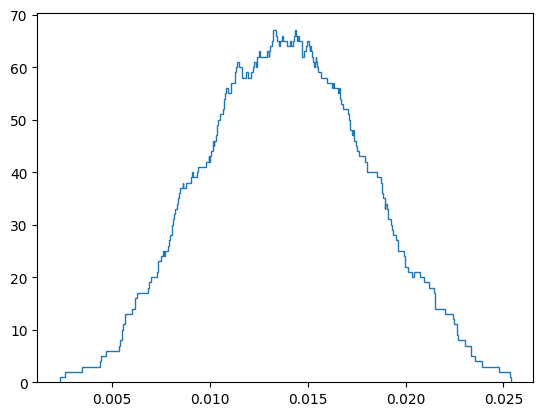

In [103]:
plt.stairs(amounts,values[:,0])

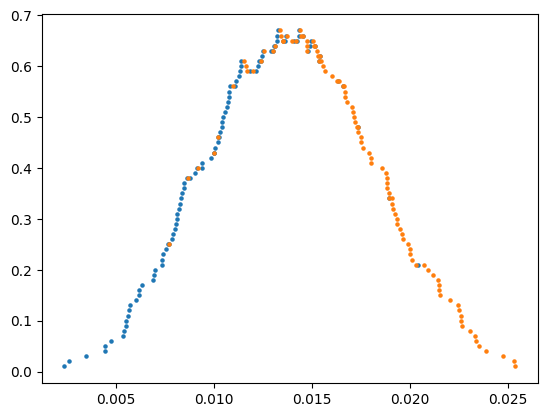

In [88]:

plt.scatter(conf_intervals[net,:,0],L_amount/100, s = 5)
plt.scatter(conf_intervals[net,:,1],U_amount/100, s = 5)

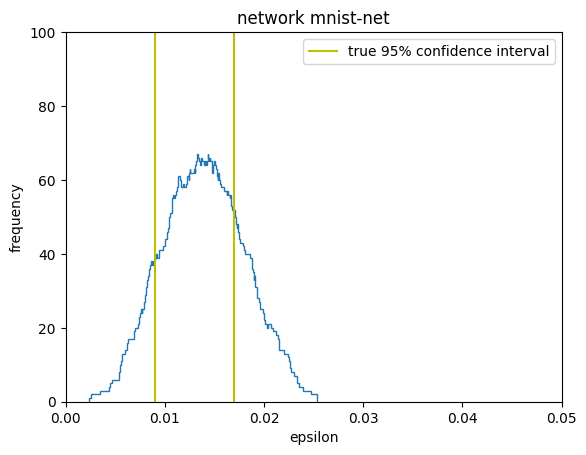

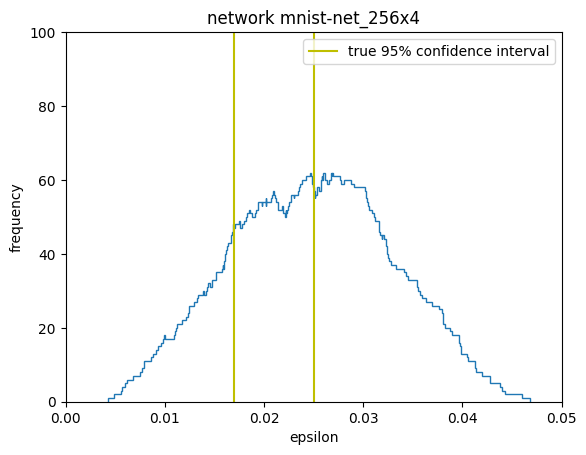

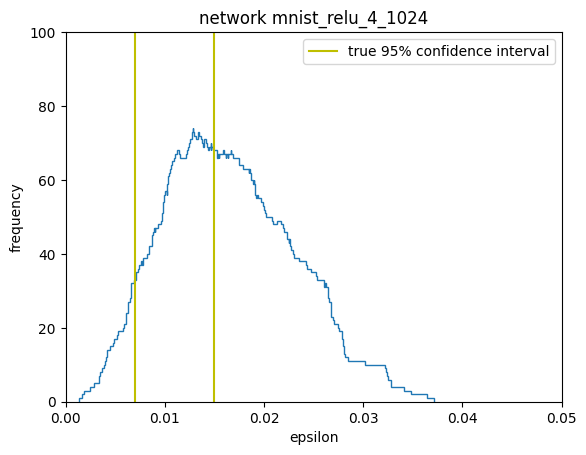

In [104]:
for net in range(len(networks)):
    # make histogram
    # first check lower bounds
    L_bigger_than_lower_bound = conf_intervals[net,:,0][:,np.newaxis] >= conf_intervals[net,:,0][np.newaxis,:]
    L_smaller_than_upper_bound = conf_intervals[net,:,0][:,np.newaxis] < conf_intervals[net,:,1][np.newaxis,:]
    
    # then check upper bounds
    U_smaller_than_upper_bound = conf_intervals[net,:,1][:,np.newaxis] <= conf_intervals[net,:,1][np.newaxis,:]
    U_bigger_than_lower_bound = conf_intervals[net,:,1][:,np.newaxis] > conf_intervals[net,:,0][np.newaxis,:]
    
    # count amount
    L_amount = (L_bigger_than_lower_bound*L_smaller_than_upper_bound).sum(axis=1)
    U_amount = (U_smaller_than_upper_bound*U_bigger_than_lower_bound).sum(axis=1)
    
    # stairs
    edges = np.copy(conf_intervals[net].reshape(-1, order = 'F'))
    side = np.tile(0, edges.shape)
    side[100:] = 1
    amounts = np.copy(np.append(L_amount,U_amount))
    # put all together into an array
    values = np.stack((edges, amounts, side), axis = 1)
    
    # sort by first index
    ind = np.argsort(values[:,0])
    
    values = values[ind]
    
    amounts = []
    for i in range(len(values)-1):
        if values[i,2] == 0:
            amounts.append(values[i,1])
        else:            
            if values[i+1,2] == 1:
                amounts.append(values[i+1,1])
            else:
                amounts.append(values[i,1]-1)
    
    # new figure
    fig, ax = plt.subplots()
    ax.stairs(amounts,values[:,0])
    
    # also show vline for confidence interval
    quantile, lower, upper = get_quantile(networks[net], 0.05)
    ax.axvline(lower, color='y', label='true 95% confidence interval')
    ax.axvline(upper+0.002, color='y')
    
    # xlim is from 0 to 0.05
    ax.set_xlim(0, 0.05)
    ax.set_ylim(0, 100)
    
    # labels
    ax.set_xlabel('epsilon')
    ax.set_ylabel('frequency')
    
    # make legend smaller
    ax.legend(loc='upper right')
    
    # title
    ax.set_title('network ' + networks[net])
    
    # save figure
    fig.savefig('Figures/histogram_' + networks[net] + '.pdf', bbox_inches='tight', dpi=300)

In [79]:
conf_intervals

array([[[0.00416417, 0.01103343],
        [0.01238666, 0.01597477],
        [0.01394664, 0.01913021],
        [0.01211357, 0.02023061],
        [0.00803274, 0.01053541],
        [0.01009455, 0.01654126],
        [0.00820379, 0.0161621 ],
        [0.01003968, 0.01683474],
        [0.00724247, 0.01738522],
        [0.0175138 , 0.01884471],
        [0.01091235, 0.01950877],
        [0.00878813, 0.01784212],
        [0.01140709, 0.02149161],
        [0.00777908, 0.0175827 ],
        [0.01229256, 0.0175733 ],
        [0.01443351, 0.02451918],
        [0.01388739, 0.02337481],
        [0.01604171, 0.02455525],
        [0.01450995, 0.02316992],
        [0.01410188, 0.02250607],
        [0.01190142, 0.0198571 ],
        [0.00883848, 0.01885999],
        [0.01235076, 0.02188245],
        [0.01346529, 0.02168061],
        [0.01588525, 0.02229321],
        [0.00810646, 0.01703883],
        [0.00691016, 0.0129836 ],
        [0.0047505 , 0.01242802],
        [0.01535063, 0.01549154],
        [0.008

In [82]:
values

array([0.00416417, 0.01238666, 0.01394664, 0.01211357, 0.00803274,
       0.01009455, 0.00820379, 0.01003968, 0.00724247, 0.0175138 ,
       0.01091235, 0.00878813, 0.01140709, 0.00777908, 0.01229256,
       0.01443351, 0.01388739, 0.01604171, 0.01450995, 0.01410188,
       0.01190142, 0.00883848, 0.01235076, 0.01346529, 0.01588525,
       0.00810646, 0.00691016, 0.0047505 , 0.01535063, 0.00868355,
       0.00890211, 0.00398249, 0.01139364, 0.00845387, 0.0188763 ,
       0.01158636, 0.0118686 , 0.01614717, 0.01006701, 0.00794072,
       0.00682421, 0.0122379 , 0.01358992, 0.01156211, 0.01066782,
       0.0059097 , 0.01756211, 0.0136498 , 0.01008275, 0.00930594,
       0.01358866, 0.01082258, 0.01131829, 0.01327639, 0.01084695,
       0.01220631, 0.01023069, 0.01975374, 0.00802121, 0.01452725,
       0.00663144, 0.01311267, 0.01300272, 0.00866046, 0.00770491,
       0.00513229, 0.00347057, 0.00926905, 0.01280161, 0.01190426,
       0.0142066 , 0.0066592 , 0.01186227, 0.01132367, 0.00844

In [81]:
values = np.append(conf_intervals[0,:,0],conf_intervals[0,:,1])
amounts = np.append(L_amount,U_amount)



ValueError: Size mismatch between "values" and "edges". Expected `len(values) + 1 == len(edges)`, but `len(values) = 100` and `len(edges) = 100`.

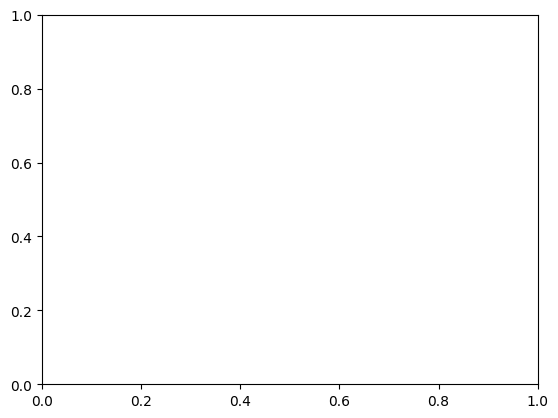

In [76]:
plt.stairs(conf_intervals[0,:,0],L_amount)